In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
from collections import defaultdict
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [3]:
config = {
    "base_dir":        "/eos/user/d/dvalsecc/www/VBSPlots/DNN_archive/FullRun2_v7/",
    "plot_config":     "FullRun2_v7",
    "cut":             "boost_sig",
    "model_version":   "v15",
}

In [4]:
import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

import yaml
model_config_file = open(model_dir + "/model_config.yml", "r")
model_config = yaml.safe_load(model_config_file)

for key in ["samples_version", "cols"]:
    config[key] = model_config[key]

In [5]:
# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [7]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight"]).values
Wnn_bkg = (bkg["weight"]).values
X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))

In [9]:
import tensorflow as tf

model = tf.keras.models.load_model(os.path.join(model_dir, "model.h5"))

model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            (None, 64)                1792      
_________________________________________________________________
batch_normalization_64 (Batc (None, 64)                256       
_________________________________________________________________
activation_13 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_116 (Dense)            (None, 64)                4160      
_________________________________________________________________
batch_normalization_65 (Batc (None, 64)                256       
_________________________________________________________________
activation_14 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_117 (Dense)            (None, 64)              

In [10]:
bkg["y"] = model.predict(scaler.transform(bkg[config["cols"]].values), batch_size=2048)
signal["y"] = model.predict(scaler.transform(signal[config["cols"]].values), batch_size=2048)

W1028 14:05:57.257668 139657100625728 ag_logging.py:146] AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7f03a05e5710> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [11]:
wjets = bkg[bkg["sample_name"] == "Wjets_HT"]
top = bkg[bkg["sample_name"] == "top"]
DY = bkg[bkg["sample_name"] == "DY"]
VV = bkg[bkg["sample_name"] == "VV"]

In [28]:
wjets.columns

Index(['weight', 'A_ww', 'Asym_vbs', 'Centr_vbs', 'Centr_ww', 'Lep_proj',
       'Lep_projw', 'Lepton_eta', 'Lepton_phi', 'Lepton_pt', 'Mtw_lep',
       'Mw_lep', 'Mww', 'PuppiMET_phi', 'PuppiMET_pt', 'R_mw', 'R_ww',
       'Rvjets_0', 'Zlep', 'Zvjets_0', 'deltaR_lep_nu', 'deltaR_lep_vbs',
       'deltaR_lep_vjet', 'deltaR_vbs', 'deltaR_vjet', 'deltaeta_lep_nu',
       'deltaeta_vbs', 'deltaphi_lep_nu', 'deltaphi_vbs', 'fatjet_TvsQCD',
       'fatjet_WvsQCD', 'fatjet_ZvsQCD', 'fatjet_subjet1_pt',
       'fatjet_subjet2_pt', 'fatjet_subjet_ptratio', 'mjj_vbs', 'mjj_vjet',
       'nJets30', 'nvtxGood', 'recoMET_pz', 'vbs_0_E', 'vbs_0_eta',
       'vbs_0_phi', 'vbs_0_pt', 'vbs_0_qgl_boost', 'vbs_1_E', 'vbs_1_eta',
       'vbs_1_phi', 'vbs_1_pt', 'vbs_1_qgl_boost', 'vjet_0_E', 'vjet_0_eta',
       'vjet_0_phi', 'vjet_0_pt', 'w_had_pt', 'w_lep_pt', 'lep_flavour',
       'sample_name', 'year', 'weight_norm', 'y'],
      dtype='object')

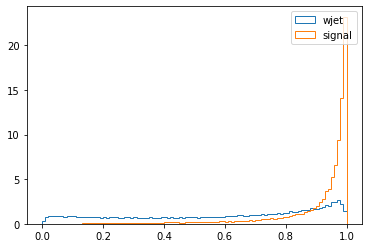

In [43]:
plt.hist(wjets.fatjet_WvsQCD,bins=100, range=(0,1),weights=wjets.weight, histtype="step",label="wjet", density=True)
plt.hist(signal.fatjet_WvsQCD,bins=100, range=(0,1), weights=signal.weight,histtype="step",label="signal", density=True)
plt.legend()

#plt.yscale("log")

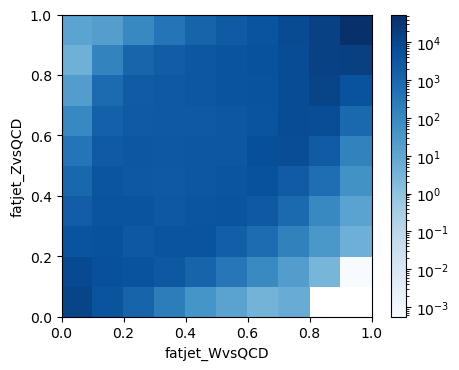

In [56]:
plt.figure(figsize=(5,4), dpi=100)
plt.hist2d(wjets.fatjet_WvsQCD, wjets.fatjet_ZvsQCD, weights=wjets.weight, cmap="Blues", range=((0,1),(0,1)), norm=colors.LogNorm())
plt.colorbar()
plt.xlabel("fatjet_WvsQCD")
plt.ylabel("fatjet_ZvsQCD")
plt.show()

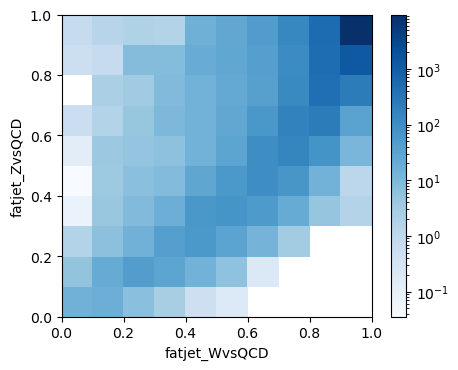

In [58]:
plt.figure(figsize=(5,4), dpi=100)
plt.hist2d(signal.fatjet_WvsQCD, signal.fatjet_ZvsQCD, weights=signal.weight, cmap="Blues", range=((0,1),(0,1)), norm=colors.LogNorm())
plt.colorbar()
plt.xlabel("fatjet_WvsQCD")
plt.ylabel("fatjet_ZvsQCD")
plt.show()

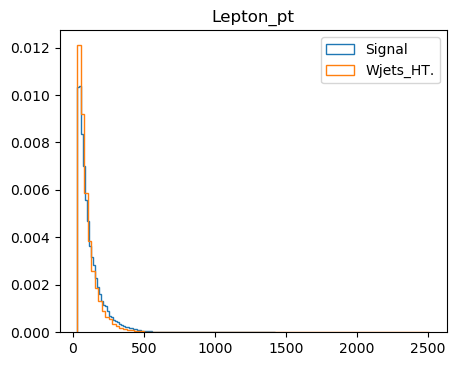

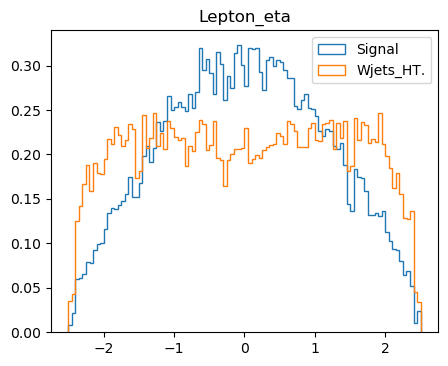

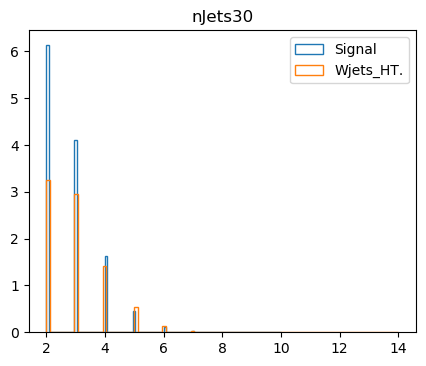

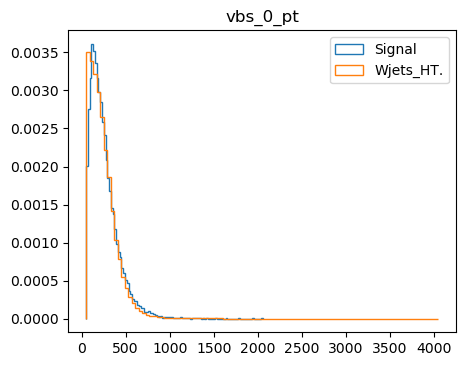

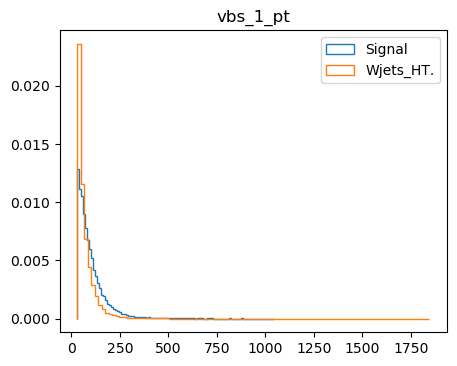

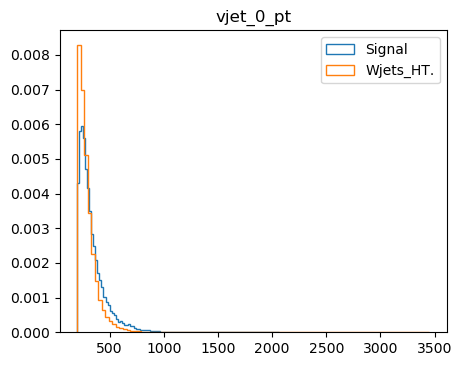

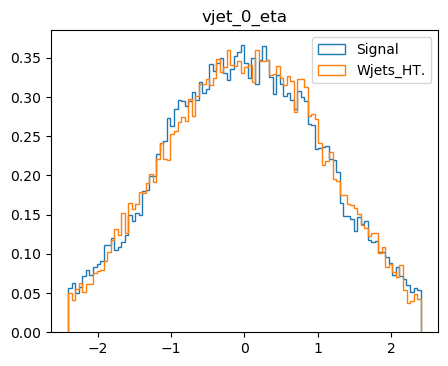

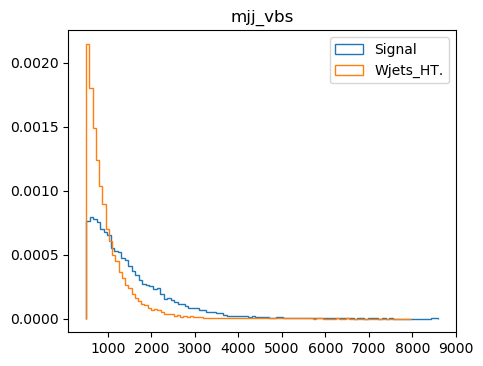

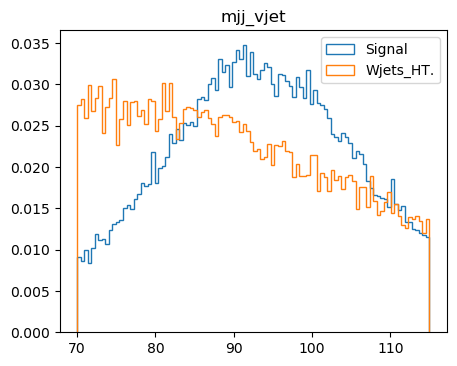

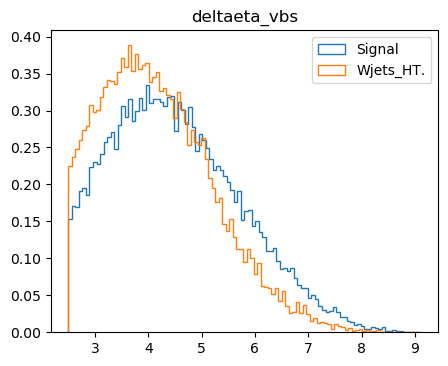

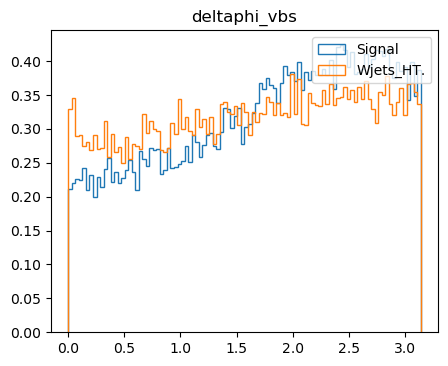

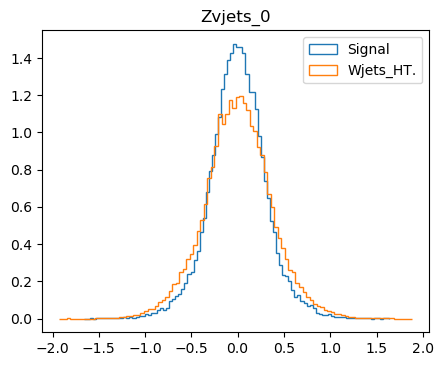

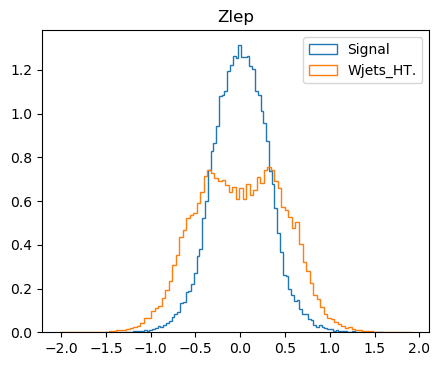

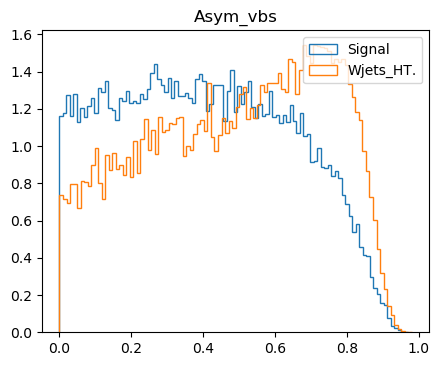

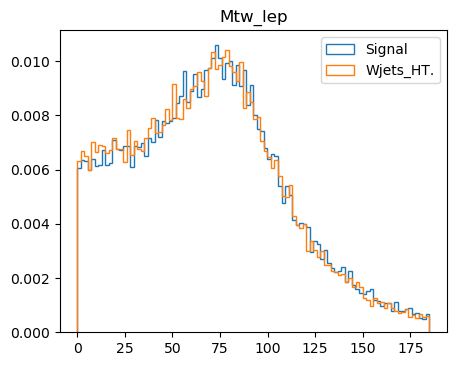

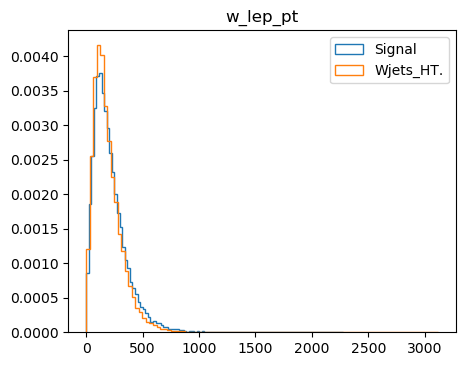

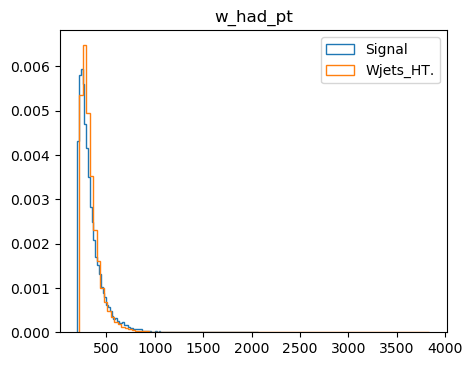

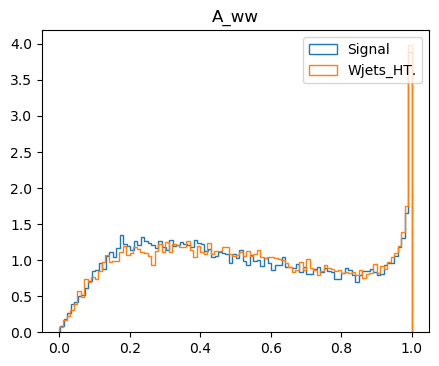

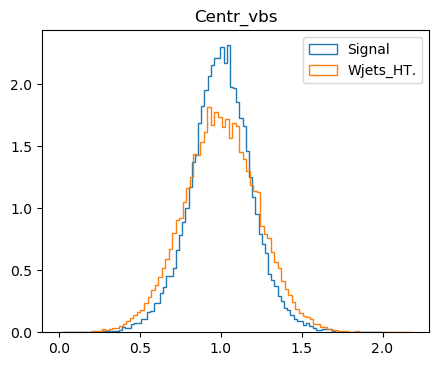

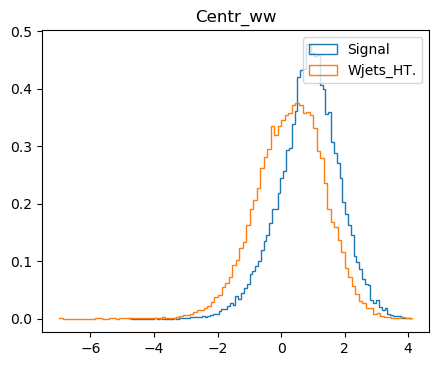

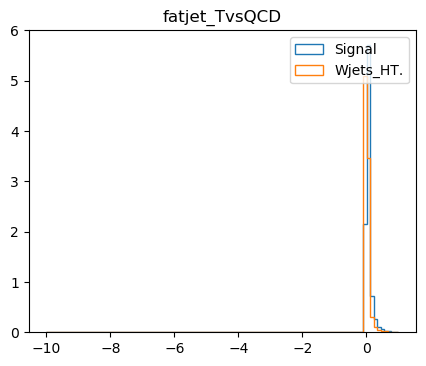

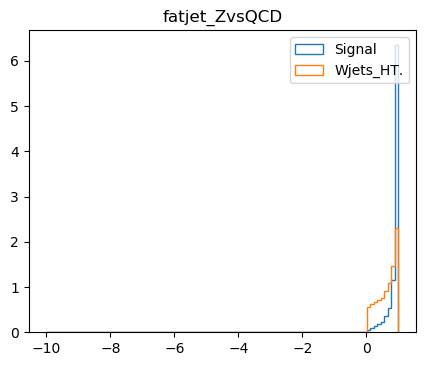

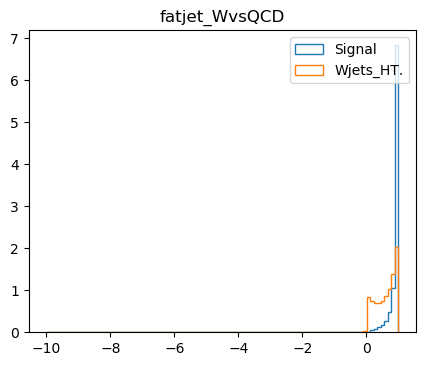

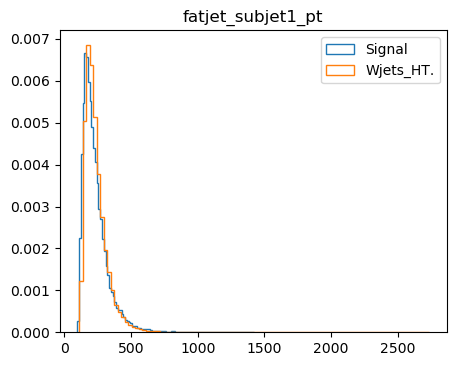

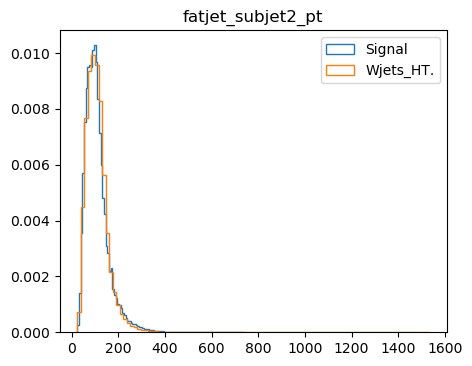

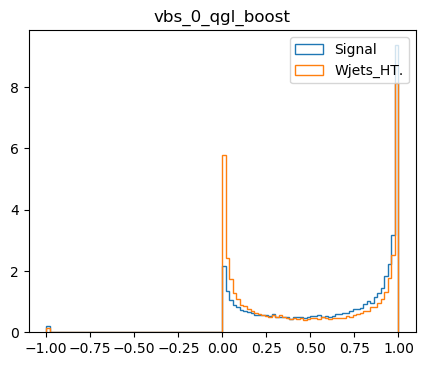

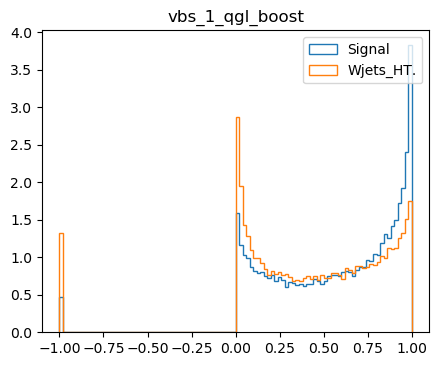

In [68]:
for idx,col in enumerate(config["cols"]):
    plt.figure(figsize=(5,4), dpi=100)
    _ = plt.hist(signal[col], bins=100, histtype="step", density=True, weights=signal.weight, label="Signal")
    _ = plt.hist(wjets[col], bins=100, histtype="step", density=True, weights=wjets.weight, label="Wjets_HT.")
    plt.legend()
    plt.title(col)
    plt.show()

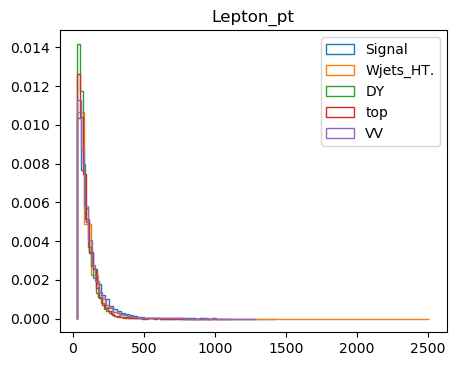

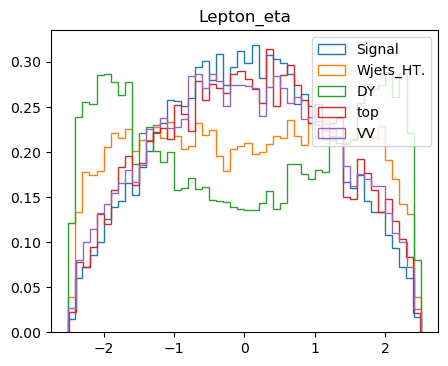

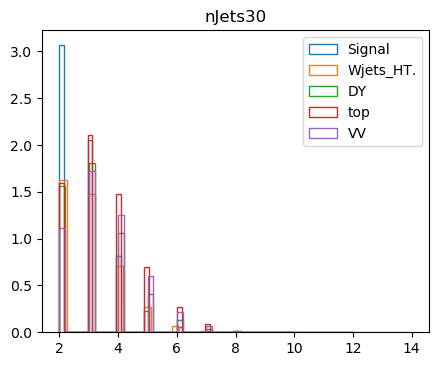

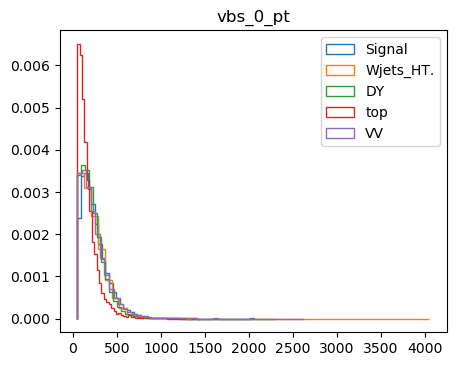

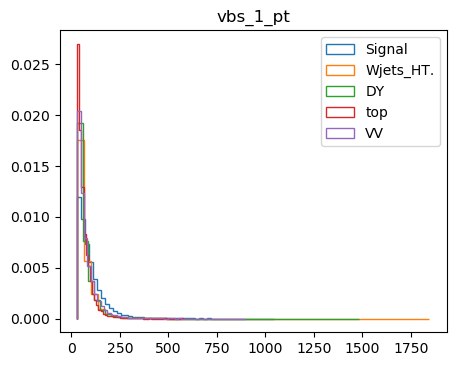

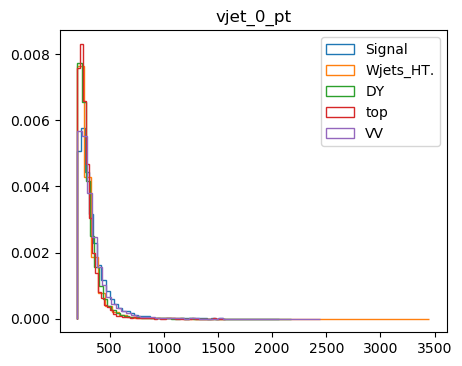

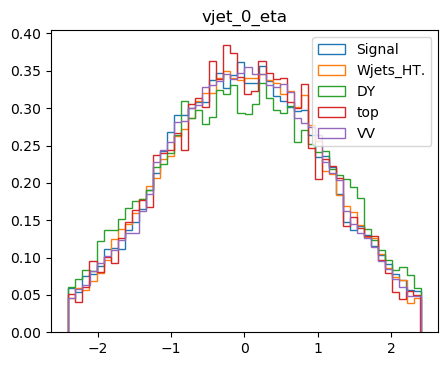

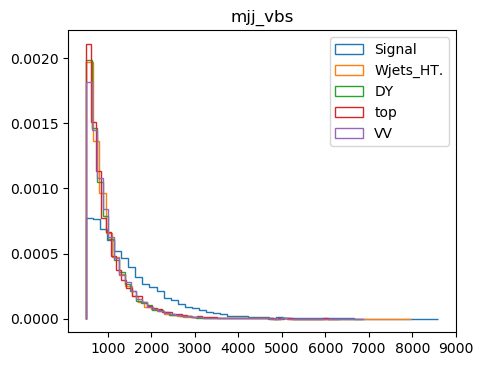

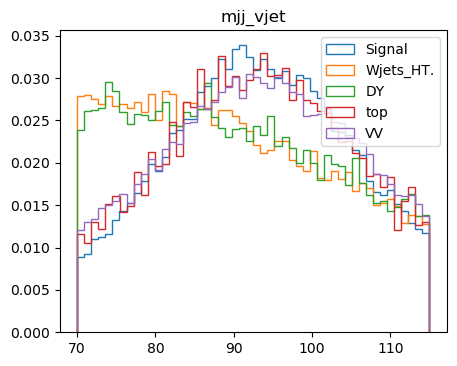

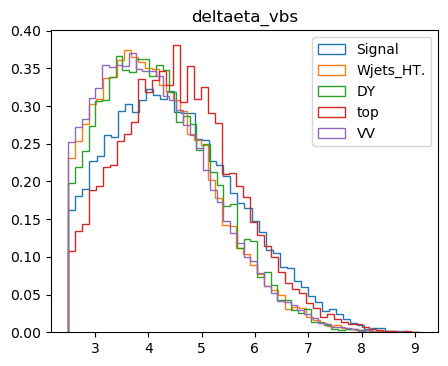

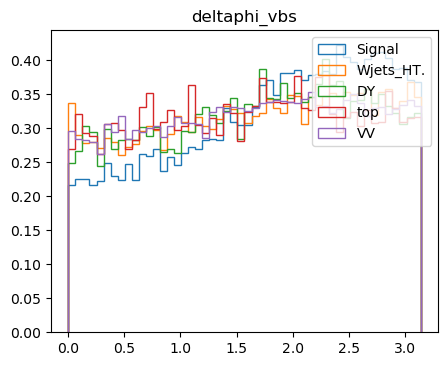

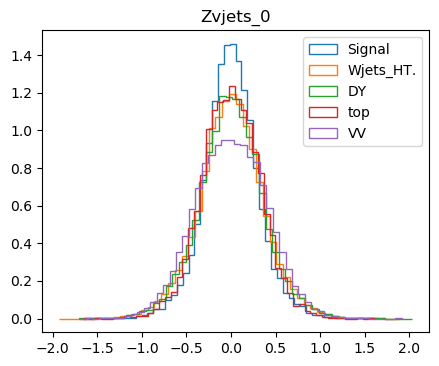

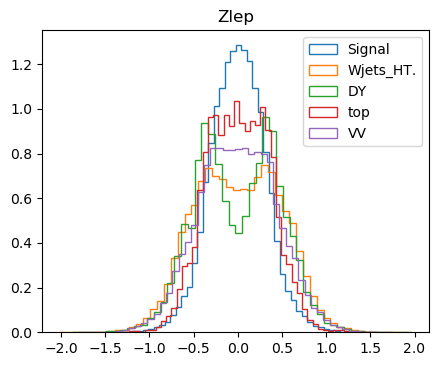

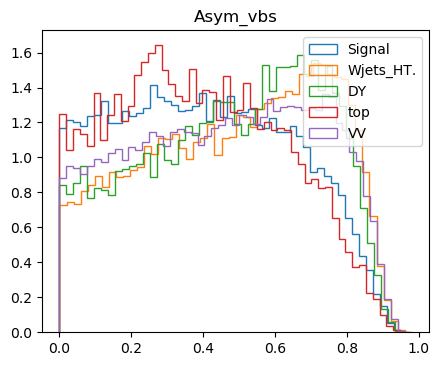

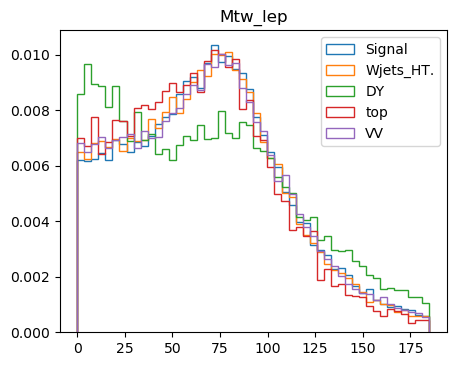

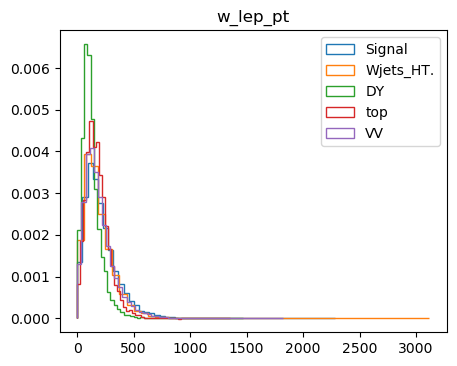

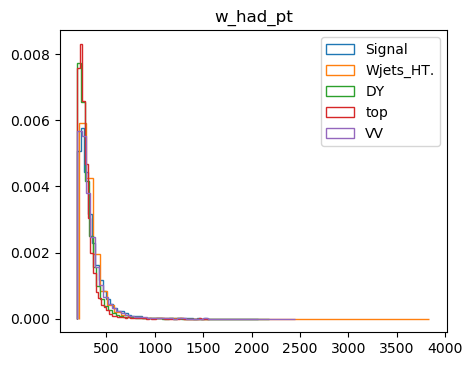

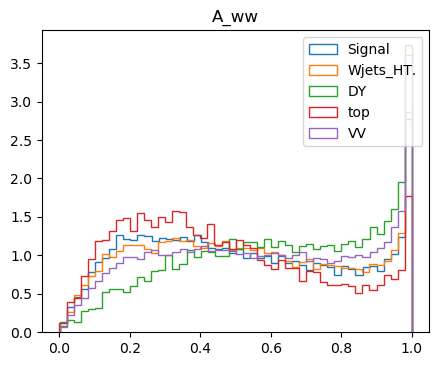

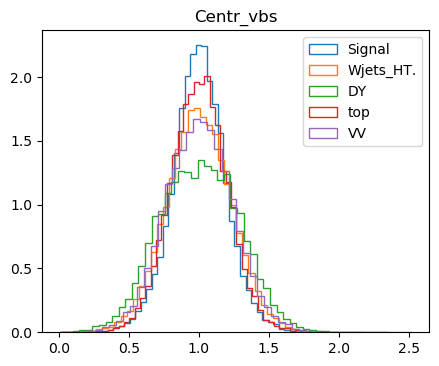

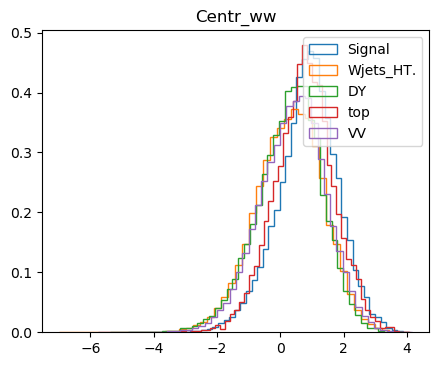

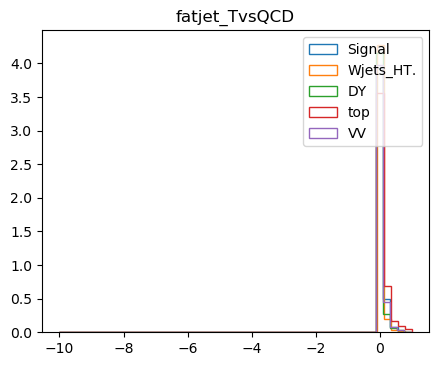

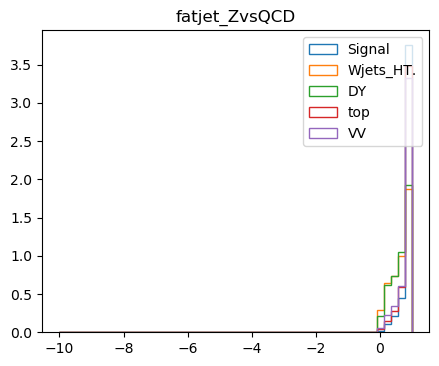

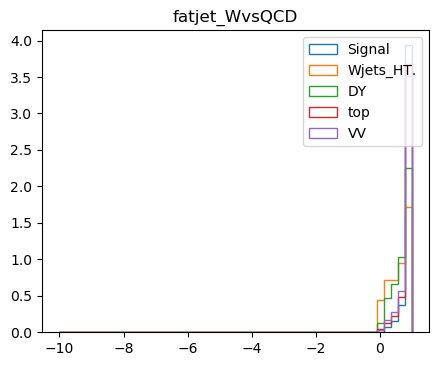

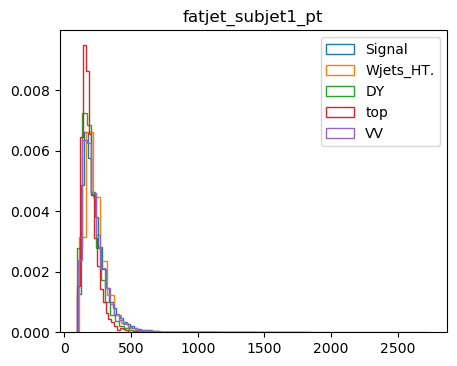

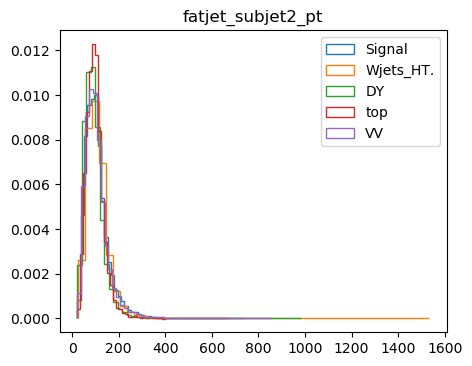

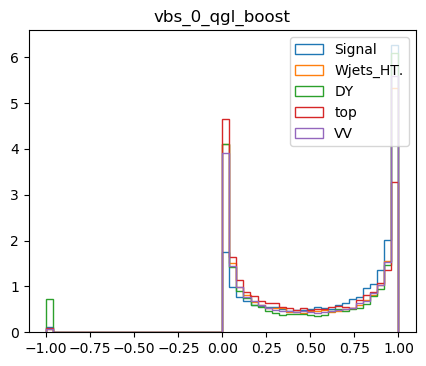

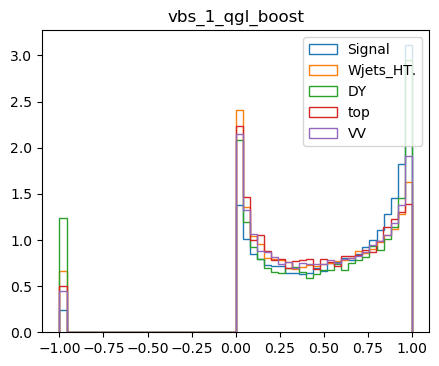

In [73]:
for idx,col in enumerate(config["cols"]):
    plt.figure(figsize=(5,4), dpi=100)
    _ = plt.hist(signal[col], bins=50, histtype="step", density=True, weights=signal.weight, label="Signal")
    _ = plt.hist(wjets[col], bins=50, histtype="step", density=True, weights=wjets.weight, label="Wjets_HT.")
    _ = plt.hist(DY[col], bins=50, histtype="step", density=True, weights=DY.weight, label="DY")
    _ = plt.hist(top[col], bins=50, histtype="step", density=True, weights=top.weight, label="top")
    _ = plt.hist(VV[col], bins=50, histtype="step", density=True, weights=VV.weight, label="VV")
    plt.legend()
    plt.title(col)
    plt.show()

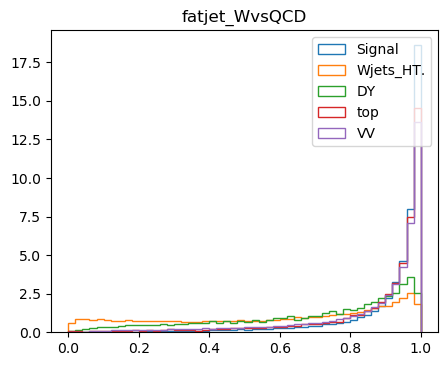

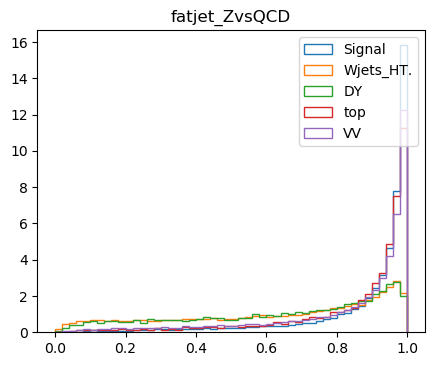

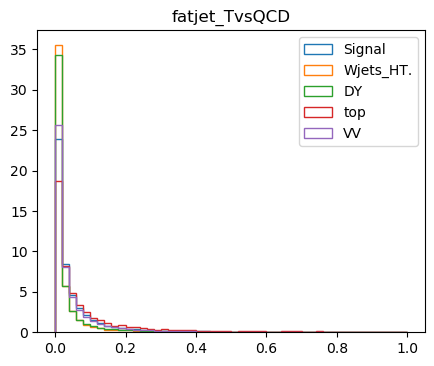

In [74]:
for idx,col in enumerate(['fatjet_WvsQCD','fatjet_ZvsQCD','fatjet_TvsQCD']):
    plt.figure(figsize=(5,4), dpi=100)
    _ = plt.hist(signal[col], bins=50,range=(0,1), histtype="step", density=True, weights=signal.weight, label="Signal")
    _ = plt.hist(wjets[col], bins=50,range=(0,1), histtype="step", density=True, weights=wjets.weight, label="Wjets_HT.")
    _ = plt.hist(DY[col], bins=50,range=(0,1),histtype="step", density=True, weights=DY.weight, label="DY")
    _ = plt.hist(top[col], bins=50, range=(0,1),histtype="step", density=True, weights=top.weight, label="top")
    _ = plt.hist(VV[col], bins=50, range=(0,1),histtype="step", density=True, weights=VV.weight, label="VV")
    plt.legend()
    plt.title(col)
    plt.show()

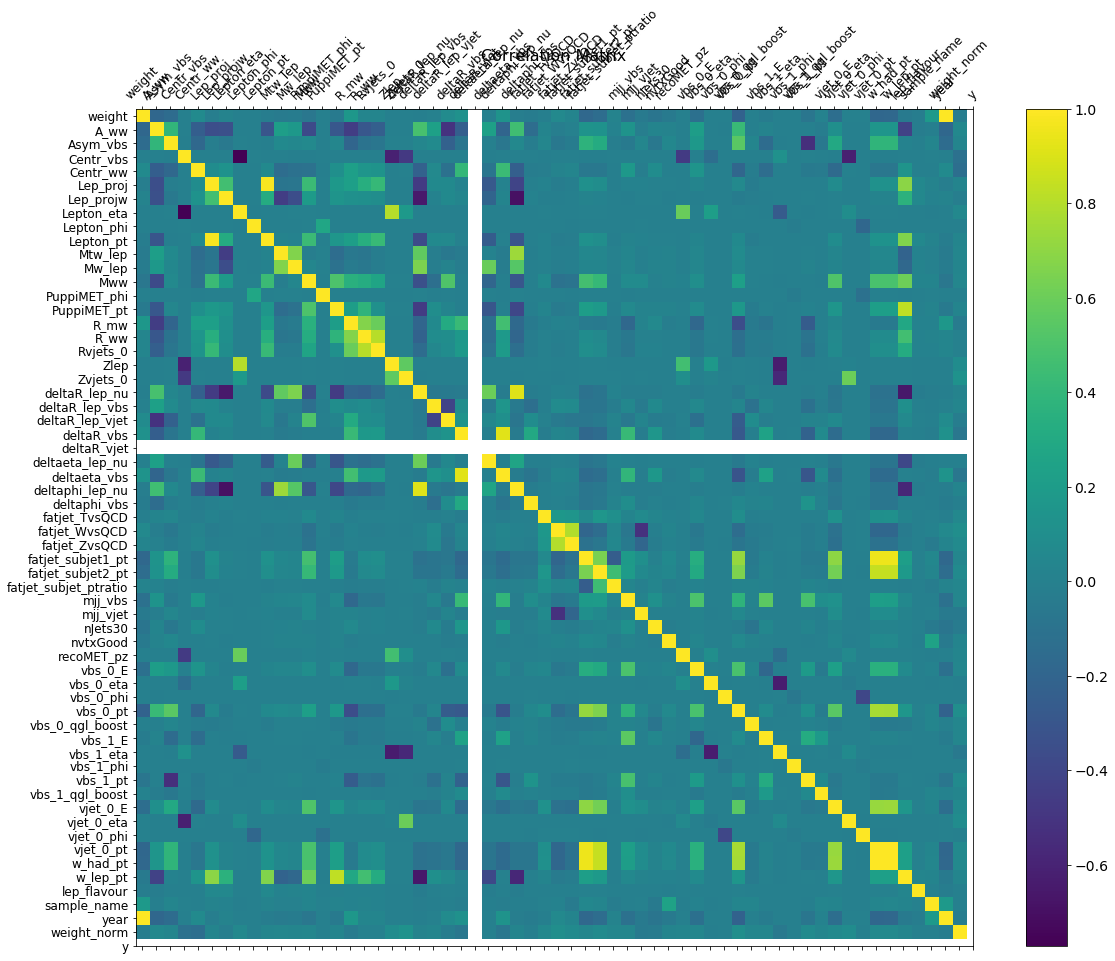

In [12]:
f = plt.figure(figsize=(19, 15))
plt.matshow(wjets.corr(), fignum=f.number)
plt.xticks(range(wjets.shape[1]), wjets.columns, fontsize=12, rotation=45)
plt.yticks(range(wjets.shape[1]), wjets.columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

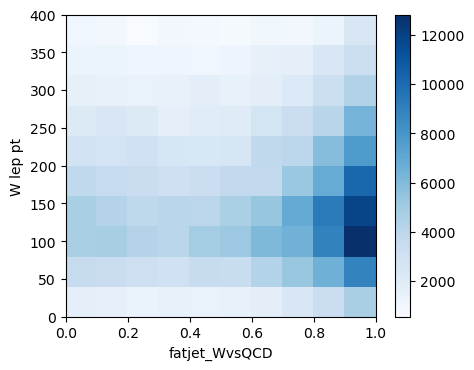

In [20]:
plt.figure(figsize=(5,4), dpi=100)
plt.hist2d(wjets.fatjet_WvsQCD, wjets.w_lep_pt, weights=wjets.weight, cmap="Blues", range=((0,1),(0,400)))
plt.colorbar()
plt.xlabel("fatjet_WvsQCD")
plt.ylabel("W lep pt")
plt.show()

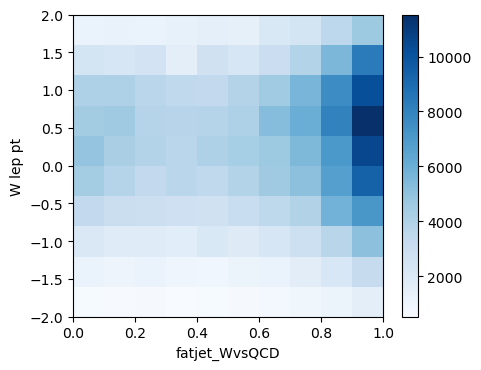

In [24]:
plt.figure(figsize=(5,4), dpi=100)
plt.hist2d(wjets.fatjet_WvsQCD, wjets.Centr_ww, weights=wjets.weight, cmap="Blues", range=((0,1),(-2,2)))
plt.colorbar()
plt.xlabel("fatjet_WvsQCD")
plt.ylabel("W lep pt")
plt.show()

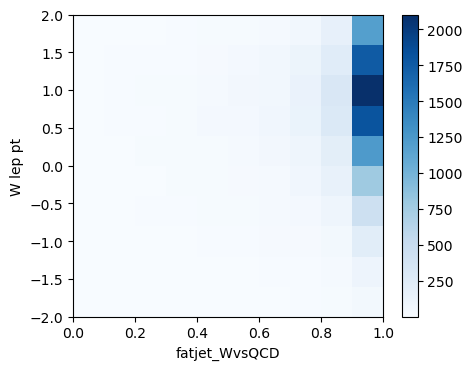

In [26]:
plt.figure(figsize=(5,4), dpi=100)
plt.hist2d(signal.fatjet_WvsQCD, signal.Centr_ww, weights=signal.weight, cmap="Blues", range=((0,1),(-2,2)))
plt.colorbar()
plt.xlabel("fatjet_WvsQCD")
plt.ylabel("W lep pt")
plt.show()

In [ ]:
plt.hist()